In [1]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import scoping.models as sm
import igraph
#import mpld3

from adjustText import adjust_text

In [2]:
# set seed
random.seed(123)

In [3]:
# create project and save tweets to project for easier callup 
# p, created = sm.Project.objects.get_or_create(title='Coal Commission')
# p.pk

In [4]:
terms =  [
    '#Kohlekommission',
    '#Kohleausstieg',
    '#Hambibleibt'
]

In [6]:
# Adding tweets to project
for t in terms:
    s, created = tm.TwitterSearch.objects.get_or_create(string=t)
    s.project = p
    s.save()
    print(f"\n{s.string}: {s.status_set.count()}")
    if s.status_set.count() > 1:
        ms = s.status_set.order_by('-retweets_count').first()
        print(f"most retweeted: {ms.retweets_count}")
        print(f"{ms.author} - {ms.created_at}")
        print(ms.text)


#Kohlekommission: 13956
most retweeted: 409
campact - @campact - 2018-08-24 09:42:14+00:00
Wenn es nach @RWE_AG geht, soll einer der ältesten Wälder Deutschlands für eine Technologie weichen, deren Ende beschlossene Sache ist. Wir appellieren an die #Kohlekommission und die #Bundesregierung: Retten Sie den #HambacherForst! Hier unterzeichnen: https://t.co/lsjUFgc1NX https://t.co/nR6vJI826G

#Kohleausstieg: 56275
most retweeted: 538
Ralph Goldmann - @RalphGoldmann - 2019-06-21 12:07:32+00:00
Das muss man hochkant sehen. 😳 #FridaysForFurture #aachen #AC2106 #kohleausstieg @ZDFheute pic.twitter.com/5DpBpDbjKm

#Hambibleibt: 121799
most retweeted: 1180
Raphael Thelen - @RaphaelThelen - 2018-10-06 13:14:12+00:00
Die neuen besorgten Bürger: - 50.000 Menschen bei #Hambibleibt - 30.000 Menschen bei #wellcomeunited in Hamburg - 100.000 bei der #Seebrücke in ganz Deutschland - 65.000 bei #wirsindmehr in Chemnitz - 40.000 bei #nopag und #ausgehetzt in München Ist das der Linksruck?


---

### Loading project, descriptives

In [5]:
p = sm.Project.objects.get(pk=196)

In [6]:
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [8]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project=p)

ttweets = set(tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
).values_list('id',flat=True))

print(len(ttweets))

155508


In [9]:
# Take a sample of the texts
texts = tm.Status.objects.filter(
    id__in=random.sample(ttweets, 20000)
).values_list('text',flat=True)


# Stem and vectorize the texts (need to remove @s?)
from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]


vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

tfidf = vectorizer.fit_transform(texts)

In [10]:
# Run tm on tweets to get general idea 
K = 10

model = NMF(
    n_components=K, random_state=1,
    alpha=0.01, l1_ratio=.91,
    init='nndsvd'
).fit(tfidf)

dtm = model.transform(tfidf)

In [11]:
tfidf_feature_names = vectorizer.get_feature_names()
def display_topics(model, feature_names, no_top_words, dtm, texts):
    for topic_idx, topic in enumerate(model.components_):
        tdocs = dtm[:,topic_idx]
        print(f"\n##############################################\n### Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        print("\n\n".join([texts[i]
                        for i in tdocs.argsort()[:-5 - 1:-1]]))
        
        
no_top_words = 10
display_topics(model, tfidf_feature_names, no_top_words, dtm, list(texts))


##############################################
### Topic 0
hambibleibt mensch hambacherwald wald schon mal heut mehr polizei dank


Heute werden wieder Tausende in den Wald ziehen, um ein Zeichen zu setzen und den Wald zu schützen. Denn es geht nicht nur um uns. Es geht um die Zukunft unserer Kinder.  #hambibleibt #hambibleibt #endcoal #nextgeneration @bund_net @KlimaAllianz @HambiBleibt

Fledermaus fallen von #RWE #HambacherForst #hambibleibt #HambacherWald @HambiBleibt #HambiBleibt  pic.twitter.com/yoz04wA5lc

Aufruf @HambiBleibt @HambacherF @anettselle @Dumpsterdive @HambiBleibt Bitte geht hin. Schmeisst dir arbeit für die Zukunft. Der Chef wird es verstehen. Oder mitgehn. 1000 können sie nicht stoppen! Please damit #StopptdenWahnsinn #Hambibleibt #hambacherforst #hambi

@HambiBleibt @HambacherF @anettselle @Dumpsterdive @HambiBleibt Bitte geht hin. Schmeisst dir arbeit für die Zukunft. Der Chef wird es verstehen. Oder mitgehn. 1000 können sie nicht stoppen! Please damit #Stopptden

In [12]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
    
print_top_words(model, tfidf_feature_names, 10)


Topic #0:
hambibleibt mensch hambacherwald wald schon mal heut mehr polizei dank

Topic #1:
kohleausstieg klimaschutz energiew kohl deutschland klimawandel schnell mehr cdu fridaysforfutur

Topic #2:
the for coal peopl from germany with are that you

Topic #3:
hambacherforst hambibleibt hambi hambacherwald polizei raumung hambacherfor aktivist endegeland baumhaus

Topic #4:
rwe braunkohl rweag nrw hambacherwald polit rod wald kohl arminlaschet

Topic #5:
fridaysforfutur hambi climatejustic endcoal climatechang extinctionrebellion climatestr gretathunberg climateemergency youthstrikeclimat

Topic #6:
kohlekommission amp kohl heut braunkohl energiew mehr klimaschutz ergebnis coal

Topic #7:
hambach forst wald hambibleibt aach polizei raumung for tagebau onlin

Topic #8:
endcoal geht via appell campact unterzeichn groko klimaziel gar aufgeb

Topic #9:
endegela end geland endcoal aktionunterholz httpstcowrlzperzd httpstcoespnfqby novemb videoplaylist httpstcovbbwcopx



In [13]:
nmf_embedding = model.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

---

In [14]:
# tsne test 
from sklearn.manifold import TSNE
tsne = TSNE(random_state=123)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

In [15]:
tsne_embedding[:10]

,x,y,hue
0,27.875771,29.409157,1
1,20.732500,19.824955,1
2,26.846338,29.658068,1
3,41.774632,22.607960,1
4,17.992664,-2.787617,1
5,81.572784,28.542866,1
6,44.011917,24.993765,1
7,44.011917,24.993765,1
8,45.900650,23.487757,1
9,22.178562,16.888596,1


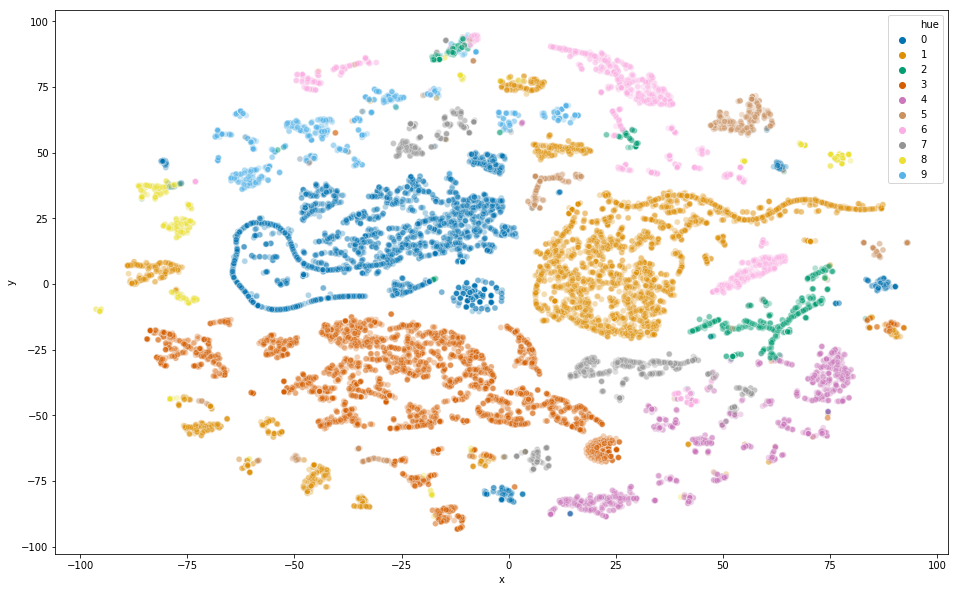

In [16]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_embedding['x'], y=tsne_embedding['y'],
    hue=tsne_embedding['hue'],
    palette=sns.color_palette("colorblind", 10),
    legend="full",
    alpha=0.3
)
plt.savefig("plots/tsne1.png", dpi=200)
plt.show()

---

### TM for #kohlekommission only

In [7]:
term = '#Kohlekommission'

In [8]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project=p)

ttweets = set(tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    text__contains=term,
    retweeted_status__isnull=True,
    created_at__lte=end_date
).values_list('id',flat=True))

print(len(ttweets))

12159


In [10]:
# Take a sample of the texts
texts = tm.Status.objects.filter(
    id__in=ttweets
).values_list('text',flat=True)

In [11]:
# Stem and vectorize the texts (need to remove @s?)
from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]


vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

tfidf = vectorizer.fit_transform(texts)

In [12]:
# Run tm on tweets to get general idea 
K = 10

model = NMF(
    n_components=K, random_state=1,
    alpha=0.01, l1_ratio=.91,
    init='nndsvd'
).fit(tfidf)

dtm = model.transform(tfidf)

In [13]:
tfidf_feature_names = vectorizer.get_feature_names()
def display_topics(model, feature_names, no_top_words, dtm, texts):
    for topic_idx, topic in enumerate(model.components_):
        tdocs = dtm[:,topic_idx]
        print(f"\n##############################################\n### Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        print("\n\n".join([texts[i]
                        for i in tdocs.argsort()[:-5 - 1:-1]]))
        
        
no_top_words = 10
display_topics(model, tfidf_feature_names, no_top_words, dtm, list(texts))


##############################################
### Topic 0
the germany out phas its beyondcoal tim hav new what


@JakobSchlandt Germany is in the spotlight over its struggle to phase out coal. The New York Times writes: “What Germany decides could have ripple effects around the world.” #Kohlekommission #BeyondCoal #Kohleausstieg https://t.co/J2hBWYae6B

@JakobSchlandt Germany is in the spotlight over its struggle to phase out coal. The New York Times writes: “What Germany decides could have ripple effects around the world.” #Kohlekommission #BeyondCoal #Kohleausstieg https://t.co/xImM8SJzlg

@JakobSchlandt Germany is in the spotlight over its struggle to phase out coal. The New York Times writes: “What Germany decides could have ripple effects around the world.” #Kohlekommission #BeyondCoal #Kohleausstieg https://t.co/vn7uLM3yrE

@Juergen_Flauger Germany is in the spotlight over its struggle to phase out coal. The New York Times writes: “What Germany decides could have ripple effects

In [14]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
    
print_top_words(model, tfidf_feature_names, 10)


Topic #0:
the germany out phas its beyondcoal tim hav new what

Topic #1:
kohleausstieg schnell bundesregier deutschland klimaziel steht dafur bundnet komm zeig

Topic #2:
via braunkohl rweag rwe appell unterzeichn campact rod darf hambacherforst

Topic #3:
hambibleibt hambacherforst rwe hambacherwald wald hambach arminlaschet rodung endegela hambi

Topic #4:
geht klima schnell kompromiss campact bleibt wirklich helf passi ungenug

Topic #5:
amp strukturwandel peteraltmai arbeit mehr polit ergebnis lausitz rwe region

Topic #6:
klimaschutz energiew beim endcoal mehr klimawandel bundesregier svenjaschulz cop strukturwandel

Topic #7:
the coal for commission climat german exit germanys germany endcoal

Topic #8:
kohl energiew ausstieg deutschland lausitz strukturwandel jahr klimawandel mehr braunkohl

Topic #9:
heut fridaysforfutur berlin mehr ergebnis zukunft mensch endegela geht schon



### Sentiment Analysis

In [40]:
import spacy
from spacy_sentiws import spaCySentiWS

In [41]:
nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)
doc = nlp('Die Dummheit der Unterwerfung blüht in hübschen Farben.')

for token in doc:
    print('{}, {}, {}'.format(token.text, token._.sentiws, token.pos_))

Die, None, DET
Dummheit, -0.4877, NOUN
der, None, DET
Unterwerfung, -0.3279, NOUN
blüht, 0.2028, VERB
in, None, ADP
hübschen, 0.4629, ADJ
Farben, None, NOUN
., None, PUNCT


In [46]:
from textblob_de import TextBlobDE as TextBlob